# Functional analysis of single-cell transcriptomics: part one

Recent advances in omics technologies have led to a rapid increase in the popularity and applications of single-cell data-sets. Standard analyses and workflows solely focus on basic preprocessing steps followed by the identification of differentially expressed genes, and their subsequent use in cell-type annotation and characterization of biological processes. In this tutorial, we show how prior knowledge can be used to extend each of the aforementioned steps, as well as to extract clear biological insights. Furthermore, we provide an introduction to the state-of-the-art intercellular communication methods, as tools for systems-level hypothesis generation tools in single-cell data. We thus cover a diverse set of prior knowledge resources and show how these can be used to support and extend analysis steps ranging from quality control, cell-type annotation and transcription factor and cytokine activity inference. Finally, we show how advanced functional omics analyses can be used to refine cell-cell communication predictions.

## Single cell transcriptomics
Single-cell transcriptomics examines the gene expression level of individual cells in a given population by simultaneously measuring the messenger RNA (mRNA) concentration of hundreds to thousands of genes. The unraveling of heterogenous cell populations, reconstruction of cellular developmental trajectories, and modeling of transcriptional dynamics (all previously masked in bulk transcriptome measurements) are made possible through analysis of this transcriptomic data.

<img src="https://upload.wikimedia.org/wikipedia/commons/d/db/RNA_Seq_Experiment.png"
     width="400" 
     height="500" />
  
Single-cell RNA-seq protocols convert a population of RNAs to a library of cDNA fragments. These fragments are sequenced by high-throughput next generation sequencing techniques and the reads are mapped back to the reference genome, providing a count of the number of reads associated with each gene.

For a review of the current state of RNA-seq check this [review](https://doi.org/10.1146/annurev-biodatasci-080917-013452) (Chen et al, 2018).

For a review on current best practices in single-cell analysis check this other [review](https://doi.org/10.15252/msb.20188746) (Luecken et al, 2019).

For tutorials and code examples check the offical `scanpy` [documentation](https://scanpy.readthedocs.io/en/stable/) (Wolf et al, 2018).


## Dataset: Blood samples from COVID-19 patients and controls
For this workshop we will work with a dataset containing blood cells coming from COVID-19 patients and controls (Silvin et al, 2020).

The data is stored in the `data` directory, where each sample is a subdirectory for each sample we have their barcodes, gene names and counts.

```
data
├── control_a
|   └── ...
├── control_b
|   └── ...
├── control_c
|   └── ...
├── covid_d
|   └── ...
├── covid_e
|   └── ...
└── covid_f
    ├── barcode.tsv.gz   # Barcodes
    ├── features.tsv.gz  # Gene names
    └── matrix.mtx.gz    # Matrix
```

The dataset consist of 3 healthy and 3 disease donors.

## Loading packages

To work with scRNA-seq data we need to load the relevant packages, `scanpy` is to handle scRNA-seq data and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import scanpy.external as sce
import decoupler as dc

# Only needed for processing and plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data loading

We start by reading the output of a squence aligner that generated a gene count matrix. With this we obtain an `AnnData` object:

In [2]:
adata = sc.read_10x_mtx('data/covid_e')
adata

AnnData object with n_obs × n_vars = 2471 × 18952
    var: 'gene_ids', 'feature_types'

Inside an `AnnData` object we have different attributes, here are the most important ones:
* X: This is where the main assay is stored. At the beginning here are the raw integer gene counts
* obs: Metadata dataframe for cells (rows)
* var: Metadata dataframe for genes (columns)
* layers: Other assays with the same dimensions than X

You can read more about it in the official [documentation](https://anndata.readthedocs.io/en/latest/index.html)

<img src="https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg"
     width="400" 
     height="500" />

To visualize the cell metadata run:

In [3]:
adata.obs

""
SAMEA6979320-AAACCCATCATCGTAG
SAMEA6979320-AAAGAACGTGCCCACA
SAMEA6979320-AAAGGATGTCGTGATT
SAMEA6979320-AAAGGATGTGTCTAAC
SAMEA6979320-AAAGGGCGTAGGCTGA
...
SAMEA6979321-TTGTTGTAGATTCGCT
SAMEA6979321-TTTGACTCACATCATG
SAMEA6979321-TTTGACTGTGAAGCGT
SAMEA6979321-TTTGATCCAATAGTGA


For the gene metadata:

In [4]:
adata.var

,gene_ids,feature_types
TSPAN6,ENSG00000000003,Gene Expression
DPM1,ENSG00000000419,Gene Expression
SCYL3,ENSG00000000457,Gene Expression
C1orf112,ENSG00000000460,Gene Expression
FGR,ENSG00000000938,Gene Expression
...,...,...
ARHGAP11A-SCG5,ENSG00000288864,Gene Expression
PPIAL4C,ENSG00000288867,Gene Expression
RPSAP58,ENSG00000288920,Gene Expression
CTAGE8-1,ENSG00000289604,Gene Expression


And the expression matrix (in sparse format to save memory):

In [5]:
adata.X

<2471x18952 sparse matrix of type '<class 'numpy.float32'>'
	with 2784120 stored elements in Compressed Sparse Row format>

## Quality Control (QC)

Before analysing the single-cell gene expression data, we must ensure that all cellular barcode data correspond to viable cells.

First we need to apply a basic filtering where we remove cells (rows) with few expressed genes and genes (columns) with that are
expressed in few cells.

In [6]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

We can then compute quality control (QC) metrics:

* `total_counts`: Total number of UMI counts for each cell. Cells with big values might be doublets*
* `pct_counts_mt`: Percentage of expressed genes that are mitocondrial. A high percentage might indicate cell death
* `n_genes_by_counts`: Number of genes that have at least one UMI count. A low value means that the cell is empty

*Doublets (or multiplets) arise in scRNA-seq data when two (or more) cells are mistakenly considered as a single cell, due for instance to being captured and processed in the same droplet on a micro-fluidics device.

In [7]:
# Compute QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

We can easly plot these metrics into scatterplots:

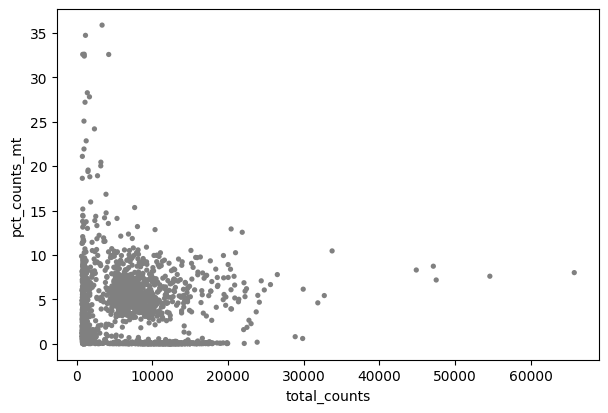

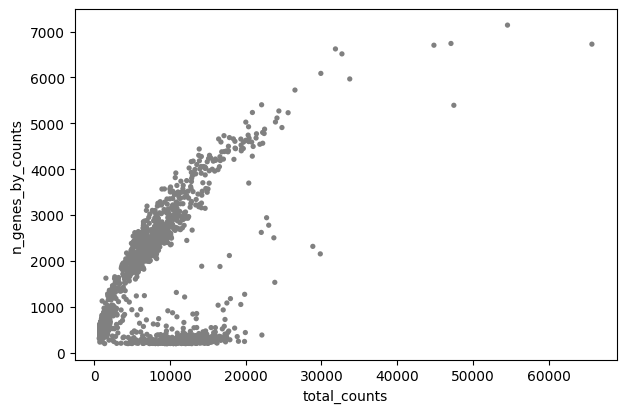

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

There seem to be some cells with higher levels of mitoconrial genes, we should remove them since these cells are not very
informative.

Moreover, it is always good to trim cells with too much number of genes expressed (`n_genes_by_counts`) because
most probably they are doublets. Cells with a very low number of `n_genes_by_counts` are not informative so we will also remove them.

We can filter our object based on these criteria:

In [9]:
# Filter cells
adata = adata[(adata.obs.n_genes_by_counts < 5000) & (adata.obs.n_genes_by_counts > 500), :]
adata = adata[adata.obs.pct_counts_mt < 15, :]
adata

View of AnnData object with n_obs × n_vars = 1430 × 16415
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

With our current filtering strategy we might still have doublets in our data which might bias downstream analyses. To
remove them, there are many methods that compute doublet scores, one of them being `scrublet` (Wolock et al, 2019). We can compute doublets scores by:

In [10]:
# Compute doublets score
sce.pp.scrublet(adata, verbose=True)

/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.36
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 35.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.8%


/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:227: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = adata_obs.obs['doublet_score']


`scrublet` computes a score that goes from 0 to 1, 1 being very probable that a cell is a doublet. We can plot the distirbution
of scores in a histogram:

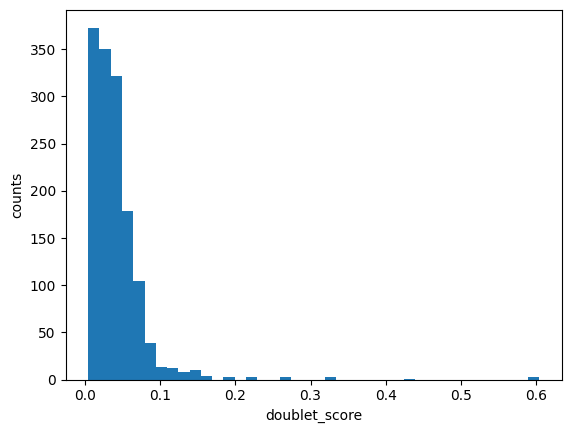

In [11]:
plt.hist(adata.obs['doublet_score'], bins=40)
plt.ylabel('counts')
plt.xlabel('doublet_score')
plt.show()

To remove outliers we can set a threshold at 0.2:

In [12]:
# Filter cells
adata = adata[adata.obs['doublet_score'] <= 0.2, :]
adata

View of AnnData object with n_obs × n_vars = 1417 × 16415
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

## Normalization

Each count in a count matrix represents the successful capture, reverse transcription and sequencing of a molecule of cellular mRNA. Count depths for identical cells can differ due to the variability inherent in each of these steps. Thus, when gene expression is compared between cells based on count data, any difference may have arisen solely due to sampling effects. Normalization addresses this issue by scaling count data to obtain correct relative gene expression abundances between cells.
The most used normalization technique is to normalize each cell by total counts over all genes, so that every cell has the same total count after normalization. Afterwards we multiply the normalized counts to the estimated library size (1e4) and we apply the log(x+1), which mitigates (but does not remove) the mean–variance relationship in single-cell data.

Before normalizing, we will store the raw integer counts into the `layers` attribute of our object

In [13]:
adata.layers['counts'] = adata.X.copy()

Then we normalize and log transform:

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

We can then store the results into another assay in the layers attribute:

In [15]:
adata.layers['logcounts'] = adata.X.copy()

## Feature selection

To identify different cell clusters in our data we first need to reduce their dimmensions by running principal component analysis (PCA) to reveal the main axes of variation and denoise the data. However before that we need to make a selection of features (genes) that maximize the differences between our cells. We can compute the Highly Variable Genes (HVG) by running this code:

In [16]:
sc.pp.highly_variable_genes(adata)

We can see which ones are flagged as HVG in the `var` attribute:

In [17]:
adata.var

,gene_ids,feature_types,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
TSPAN6,ENSG00000000003,Gene Expression,3,False,3,0.001435,99.856528,3.000000,False,0.002877,0.412386,-0.922549
DPM1,ENSG00000000419,Gene Expression,381,False,381,0.266029,81.779053,556.267578,False,0.474737,1.598283,-0.314380
SCYL3,ENSG00000000457,Gene Expression,45,False,45,0.024390,97.847920,51.000000,True,0.078718,2.044813,1.156439
C1orf112,ENSG00000000460,Gene Expression,16,False,16,0.009565,99.234816,20.000000,True,0.023811,1.938041,1.020459
FGR,ENSG00000000938,Gene Expression,240,False,240,0.237207,88.522238,496.000000,False,0.609669,2.105544,0.374901
...,...,...,...,...,...,...,...,...,...,...,...,...
H2AC18,ENSG00000288825,Gene Expression,1095,False,1095,1.325030,47.632712,2770.637939,True,2.374176,3.735275,0.630131
H2AC19,ENSG00000288859,Gene Expression,1095,False,1095,1.327900,47.632712,2776.637695,True,2.378414,3.735636,0.630474
ARHGAP11A-SCG5,ENSG00000288864,Gene Expression,24,False,24,0.002989,98.852224,6.250000,False,0.008648,0.301868,-1.063300
RPSAP58,ENSG00000288920,Gene Expression,439,False,439,0.594093,79.005261,1242.248047,True,0.823622,2.528338,0.891966


## Dimensionality reduction

Once we have a set of genes that account for the most variability in our data, we can scale our features and apply PCA.

In [18]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

The obtained PCs are stored in the `obsm` attribute:

In [19]:
adata.obsm['X_pca']

array([[ -1.9682444 ,  -9.480983  ,  29.57738   , ...,   1.2646086 ,
          1.2882497 ,   1.514131  ],
       [ -6.7481256 , -10.97887   ,  -2.5459614 , ...,  -5.8227305 ,
         -7.0402856 ,   0.8685303 ],
       [ -1.4002874 ,   9.225351  ,  -2.583631  , ...,  -0.20838846,
          0.7071866 ,  -2.3981788 ],
       ...,
       [ -1.7155488 ,   7.5928307 ,  -2.6431992 , ...,   0.03813709,
          0.6193293 ,  -1.4797611 ],
       [  1.1164954 ,   7.9159613 ,   0.27475893, ...,   0.36533725,
         -0.9630526 ,   0.86469907],
       [ -2.3300912 ,   0.21925269,   5.4236093 , ...,   1.4307058 ,
          3.6100225 ,  -0.740912  ]], dtype=float32)

## Visualization

For visualization purposes, it is standard practice to use non-linear dimensionality reduction methods, for example Uniform Approximation and Projection method (UMAP).

To run UMAP, first we need to compute a neighbouring graph between cells from the PCs space and them run the algorithm:

In [20]:
# Compute neighbours and UMAP embedding
sc.pp.neighbors(adata)
sc.tl.umap(adata)

We can then find clusters in the neighbour graph which hopefully will belong to different cell types. To find clusters there
are different algorithms available, here we will use the leiden algorithm:

In [21]:
# Find clusters in the NN graph
sc.tl.leiden(adata)

We can visualize the obtained clusters in the UMAP embedding. We can also plot the expression of genes into the UMAP,
for example CD40, a known marker gene for B cells:

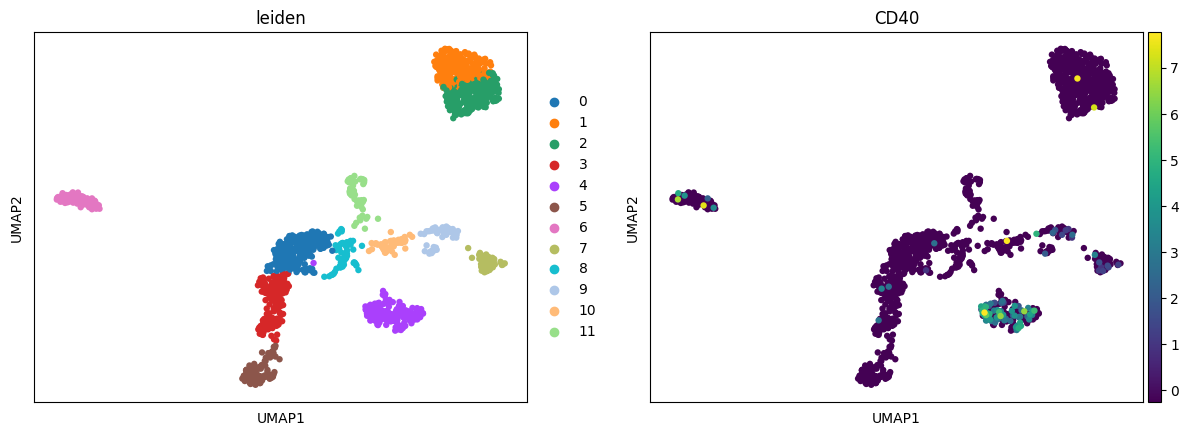

In [22]:
# Visualize UMAP
sc.pl.umap(adata, color=['leiden','CD40'])

## Annotation

Identifying and annotating clusters relies on using external sources of information describing the expected expression profiles of individual cell identities. To do so, we need to identify first marker gene sets by applying differential expression (DE) testing between two groups: the cells in one cluster and all other cells in the dataset.

As marker genes are expected to have strong differential expression effects, simple statistical tests such as the t-test are often used to rank genes by their difference in expression between these two groups. The top-ranked genes from the respective test statistic are regarded as marker genes. Then, clusters can be annotated by comparing marker genes from the dataset and marker genes from prior knowledge.

To compute marker genes run:

In [23]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', layer='logcounts')

We can extract the results as a dataframe with the following function:

In [24]:
df = sc.get.rank_genes_groups_df(adata, group=None)
df

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,RPL10P9,47.840103,4.417025,2.337991e-272,1.918906e-268
1,0,RPS26,47.145580,3.843513,4.299389e-284,7.057446e-280
2,0,RPS4X,44.183022,3.756203,2.936766e-267,1.606900e-263
3,0,RPSA,43.324078,3.474862,4.153952e-257,1.363743e-253
4,0,RPL3,42.828316,3.598168,1.061717e-257,4.357023e-254
...,...,...,...,...,...,...
196975,11,HLA-B-1,-27.198971,-5.203093,6.029800e-88,7.613782e-85
196976,11,HLA-E-2,-27.750515,-4.556638,1.892820e-44,1.538150e-42
196977,11,TAPBP-2,-28.730949,-6.227632,6.049096e-135,9.929591e-131
196978,11,SMCHD1,-29.573252,-5.020846,2.724810e-59,6.127089e-57


We can then visualize the top 3 identified marker genes per cluster using a dotplot:

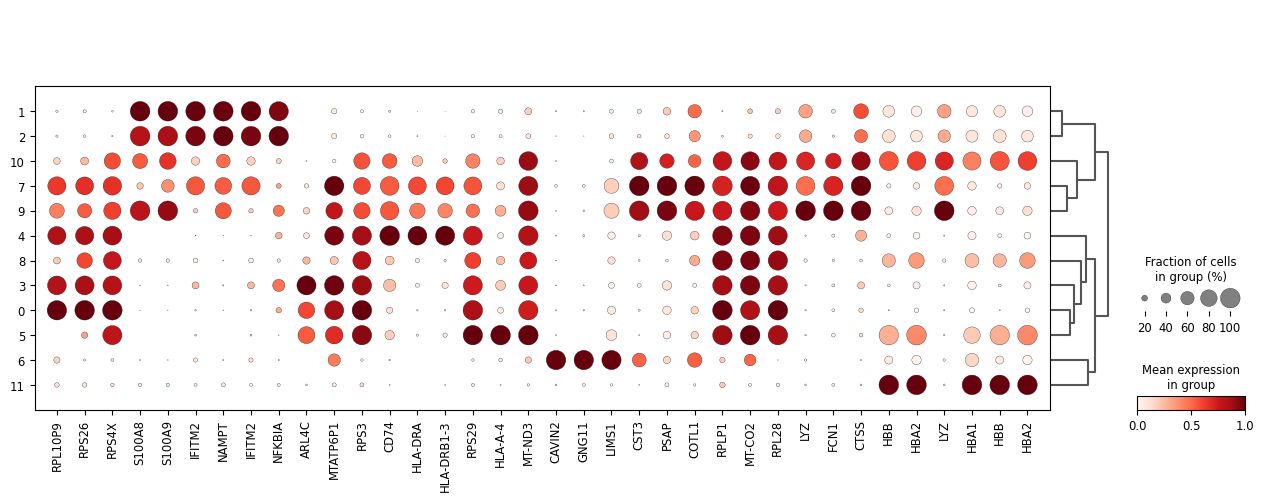

In [25]:
markers = df.groupby('group').head(3)['names'].values
sc.pl.dotplot(adata, var_names=markers, groupby='leiden', dendrogram=True, standard_scale='var')

Some clusters show well known marker genes for immune cell types. If we take a closer look we can manually annotate the obtained
clusters. Note that it is possible that some clusters might be annotated as the same cell type if their marker genes overlap.

In [26]:
annotation_dict = {
 '0': 'T cells',
 '1': 'Neutrophils',
 '2': 'Neutrophils',
 '3': 'T cells',
 '4': 'B cells',
 '5': 'T cells',
 '6': 'Platelets',
 '7': 'Monocytes',
 '8': 'T cells',
 '9': 'Monocytes',
 '10': 'Dendritic cells',
 '11': 'Erythroid-like and erythroid precursor cells',
}

Then, we can add a metadata column with the annotated cell types and visualize the results:

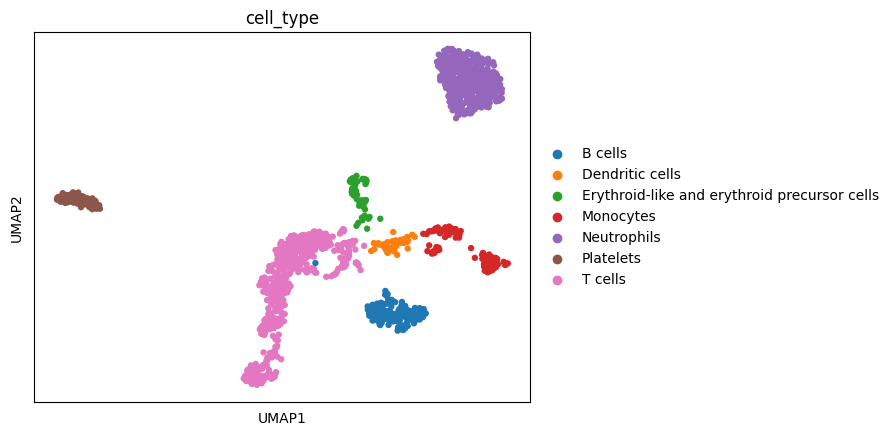

In [27]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

## Integration

Up until one we were working with just one of the samples in our dataset. To be able to make comparisons between healthy and
disease patients we need to process the other samples and merge them together.

We will read the different samples, apply the previously explained QC steps and normalization, and merge all cells into one single
object. To achieve this, we will define some functions that perform the mentioned steps:

In [28]:
def qc_sample(sample_id):
    """
    Reads and performs QC on a given sample.
    """

    # Read
    adata = sc.read_10x_mtx(os.path.join('data', sample_id))

    # Basic filtering
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    # Compute QC metrics
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    # Filter cells
    adata = adata[(adata.obs.n_genes_by_counts < 5000) & (adata.obs.n_genes_by_counts > 500), :]
    adata = adata[adata.obs.pct_counts_mt < 15, :]

    # Compute doublets score
    sce.pp.scrublet(adata, verbose=False)

    # Filter cells
    adata = adata[adata.obs['doublet_score'].values <= 0.2, :]

    return adata

def norm_sample(adata):
    """
    Normalizes, transforms and stores counts.
    """

    # Store raw counts
    adata.layers['counts'] = adata.X.copy()

    # Normalize and log transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Store logcounts
    adata.layers['logcounts'] = adata.X.copy()

    return adata

In [29]:
# Define metadata
metadata = pd.DataFrame([
    ['control'],
    ['control'],
    ['control'],
    ['covid'],
    ['covid'],
    ['covid']],
    columns=['condition'],
    index=['control_a', 'control_b', 'control_c', 'covid_d', 'covid_e', 'covid_f']
)
metadata

,condition
control_a,control
control_b,control
control_c,control
covid_d,covid
covid_e,covid
covid_f,covid


In [30]:
# Init empty adata
adata = []

# Iterate samples
for sample_id in metadata.index:

    print(sample_id)

    # QC and normalize sample
    s_adata = qc_sample(sample_id)
    s_adata = norm_sample(s_adata)

    # Add metadata
    s_adata.obs['sample_id'] = sample_id
    s_adata.obs['condition'] = metadata.loc[sample_id, 'condition']
    
    # Add to rest
    adata.append(s_adata)

# Merge adatas into one
adata = adata[0].concatenate(adata[1:], join="outer")

control_a


/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:227: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = adata_obs.obs['doublet_score']


control_b


/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:227: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = adata_obs.obs['doublet_score']


control_c


/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:227: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = adata_obs.obs['doublet_score']


covid_d


/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:227: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = adata_obs.obs['doublet_score']


covid_e


/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:227: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = adata_obs.obs['doublet_score']


covid_f


/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:227: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = adata_obs.obs['doublet_score']
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


We can notice that now in the `obs` we see we have different samples and conditions:

In [31]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,doublet_score,predicted_doublet,sample_id,condition,batch
SAMEA6979313-AAAGAACCACCTGCTT-0,2467,2462,8641.469727,672.979980,7.787796,0.037037,False,control_a,control,0
SAMEA6979313-AAAGGGTGTCCCTCAT-0,1063,1062,1761.198730,33.000000,1.873724,0.011820,False,control_a,control,0
SAMEA6979313-AACAGGGAGATCACTC-0,2864,2859,8712.615234,748.942871,8.596075,0.124424,False,control_a,control,0
SAMEA6979313-AACCAACGTGTGAGCA-0,4126,4122,16802.511719,995.628357,5.925473,0.085911,False,control_a,control,0
SAMEA6979313-AACCCAAAGTATGATG-0,2723,2715,9438.226562,580.937500,6.155155,0.054726,False,control_a,control,0
...,...,...,...,...,...,...,...,...,...,...
SAMEA6979322-TTGTTTGCACACACTA-5,2955,2927,11675.593750,560.390381,4.799674,0.073171,False,covid_f,covid,5
SAMEA6979322-TTGTTTGGTACGATGG-5,1807,1799,3762.827637,80.352943,2.135441,0.031161,False,covid_f,covid,5
SAMEA6979322-TTTACTGCAAGCGAAC-5,4128,4097,12357.002930,676.806030,5.477105,0.013972,False,covid_f,covid,5
SAMEA6979322-TTTGATCCAATAGTGA-5,4493,4464,16647.265625,931.898315,5.597906,0.017241,False,covid_f,covid,5


Like before, we need to find HVG. In this case, we will compute them per sample and then select the top 3000 genes that are HVG
across as many samples as possible:

In [32]:
# Compute HVG
sc.pp.highly_variable_genes(adata, batch_key='batch', layer='logcounts')

# Filter by HVG
num_hvg_genes = 3000
batch_msk = np.array(adata.var['highly_variable_nbatches'] > 1)
hvg = adata.var[batch_msk].sort_values('highly_variable_nbatches').tail(num_hvg_genes).index
adata.var['highly_variable'] = [g in hvg for g in adata.var.index]

/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_ge

Once we find HVG that are representative in all samples, we can scale and compute PCA on them.

In [33]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

# Remove scaled counts and put back logcounts
adata.X = adata.layers['logcounts'].copy()

The next step would be to perform UMAP but we need to consider batch effects.
Batch effects can occur when cells are handled in distinct groups. These groups can consist of cells on different chips, cells in different sequencing lanes or cells harvested at different time points. The differing environments experienced by the cells can have an effect on the measurement of the transcriptome or on the transcriptome itself.

To correct for these effects we need to integrate the samples by correcting by technical effects. Different methods of integration
exists, all of them work on correcting the cell embeddings (not directly on the gene expression) to regress this unwanted variability.
As an example we will use `harmony` (Korsunsky et al. 2019) which modifies the PCs into comparable features across batches:

In [34]:
sce.pp.harmony_integrate(adata, 'batch', max_iter_harmony=30)

2022-09-16 19:24:48,490 - harmonypy - INFO - Iteration 1 of 30
2022-09-16 19:24:49,796 - harmonypy - INFO - Iteration 2 of 30
2022-09-16 19:24:51,154 - harmonypy - INFO - Iteration 3 of 30
2022-09-16 19:24:52,693 - harmonypy - INFO - Iteration 4 of 30
2022-09-16 19:24:53,441 - harmonypy - INFO - Iteration 5 of 30
2022-09-16 19:24:53,985 - harmonypy - INFO - Converged after 5 iterations


Once we have the corrected PCs, we can compute NN and the UMAP embedding:

In [35]:
# Compute neighbours and UMAP embedding
sc.pp.neighbors(adata)
sc.tl.umap(adata)

We can also find clusters:

In [36]:
# Find clusters in the NN graph
sc.tl.leiden(adata)

Here we visualize the obtained clusters, the original sample ids and their condition:

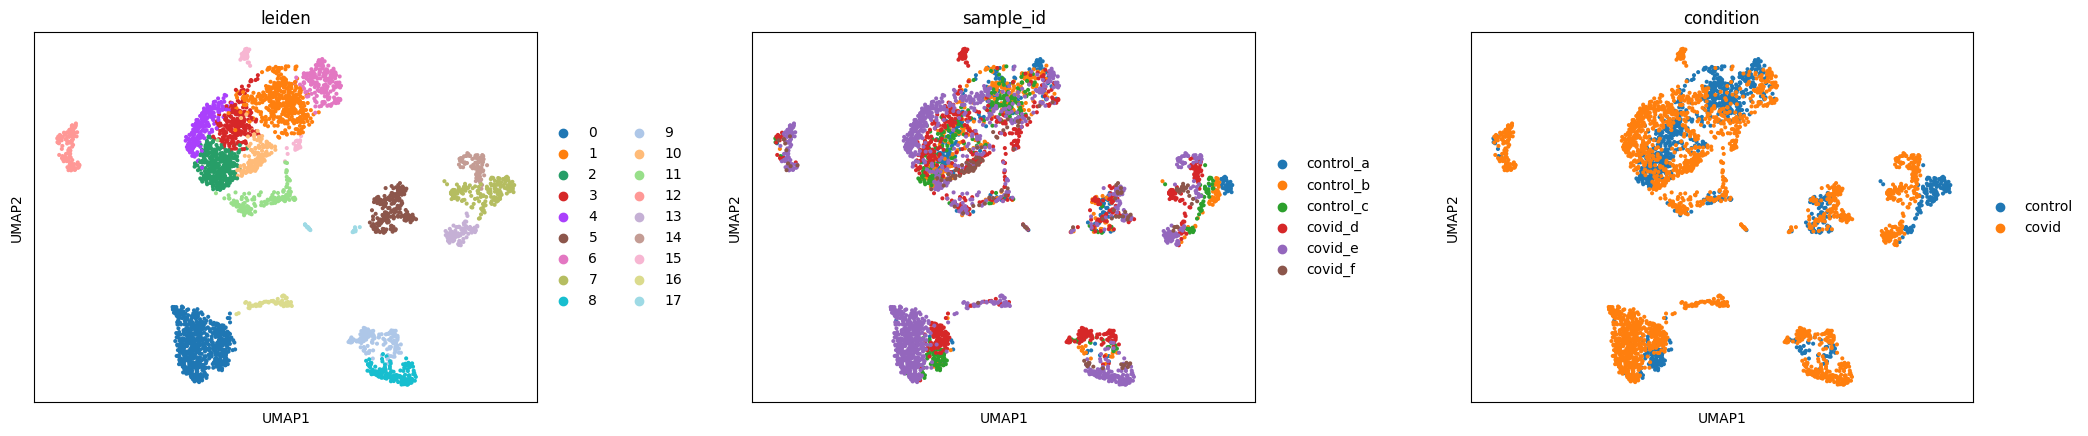

In [37]:
# Visualize UMAP
sc.pl.umap(adata, color=['leiden', 'sample_id', 'condition'], wspace=0.3)

We can observe that almost all defined clusters seem to come from multiple samples, meaning that the integration worked.

## Automatic cell type annotation

Before we showed that if we look at the marker genes of a given cluster, we could manually annotate the cell clusters with known
marker genes. This process if done manually over dozens of clusters can become tedious but it can become automated with the use
of gene sets.

Gene sets are groups of genes that can be associated to a biological term such as pathways, diseases or in this case cell types.

Thanks to recent and ongoing efforts such as the Human Cell Atlas (Regev et al, 2017), reference databases are increasingly becoming available. One of them is PanglaoDB, a database of markers for human and mouse.

We can access PanglaoDB trough OmniPath, a meta-resource of databases, and filter it by canonical human genes:

In [38]:
# Retrieve database
panglaodb = dc.get_resource('PanglaoDB')

# Filter by canonical_marker and human
panglaodb = panglaodb[(panglaodb['human']=='True') & (panglaodb['canonical_marker']=='True')]

# Remove duplicated entries
panglaodb = panglaodb[~panglaodb.duplicated(['cell_type', 'genesymbol'])]
panglaodb

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
5,KLK1,True,Principal cells,Mesoderm,True,0.0,0.00814536,True,0.285714,0.0140583,9606,Kidney,0.013
7,KLK1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.0,0.00820189,True,1.0,0.0129136,9606,Immune system,0.013
8,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8473,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8474,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8475,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


We can then use the framework `decoupler` to perform Over Representation Analysis and enrich each cell for cell type annotations:

In [39]:
dc.run_ora(mat=adata, net=panglaodb, source='cell_type', target='genesymbol', min_n=3, verbose=True, use_raw=False)

8 features of mat are empty, they will be removed.
Running ora on mat with 3467 samples and 17237 targets for 128 sources.


100%|█████████████████████████████████████| 3467/3467 [00:05<00:00, 599.41it/s]
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


We can then extract the enrichment scores into a new object:

In [40]:
acts = dc.get_acts(adata, 'ora_estimate')

Let us visualize some of the enrichments:

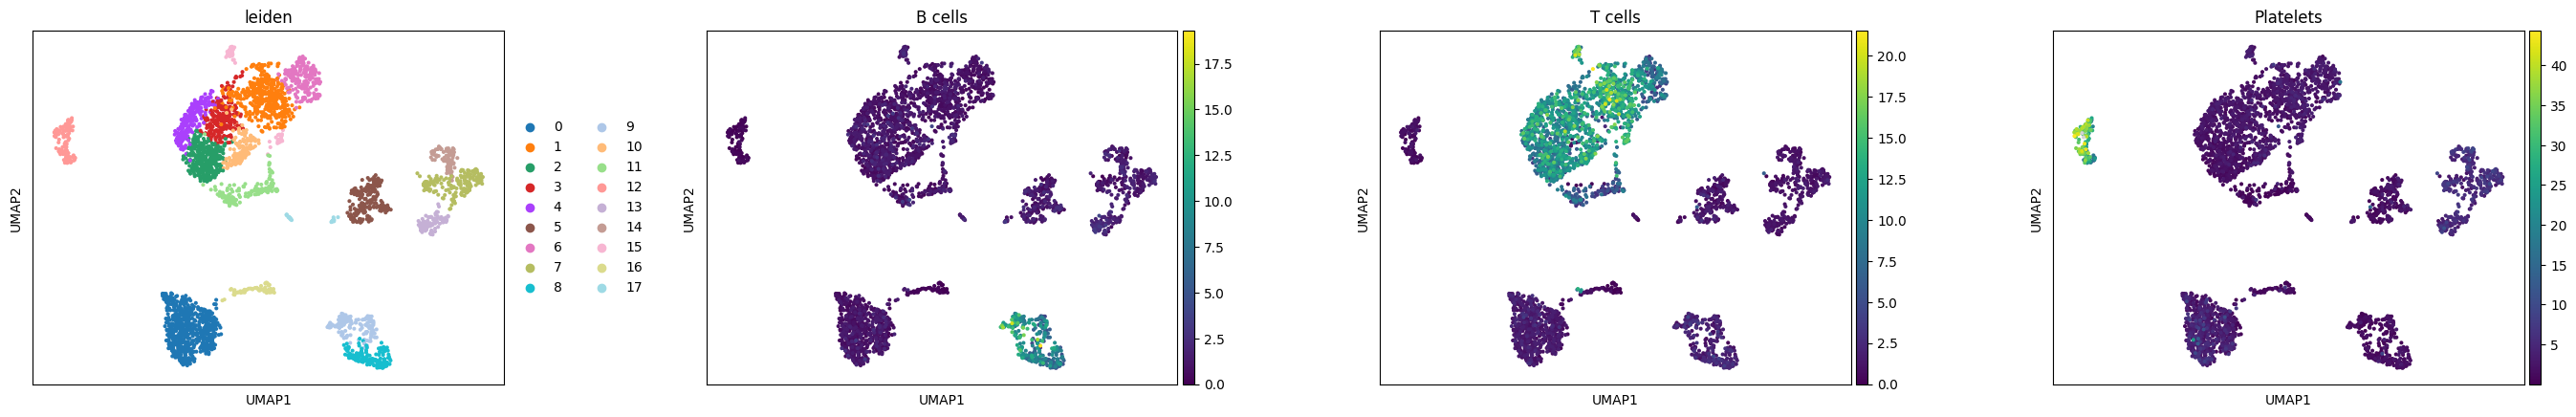

In [41]:
# Visualize UMAP
sc.pl.umap(acts, color=['leiden', 'B cells', 'T cells', 'Platelets'], wspace=0.3)

We can also extract the mean enrichment per cluster and visualize it as a clustermap:

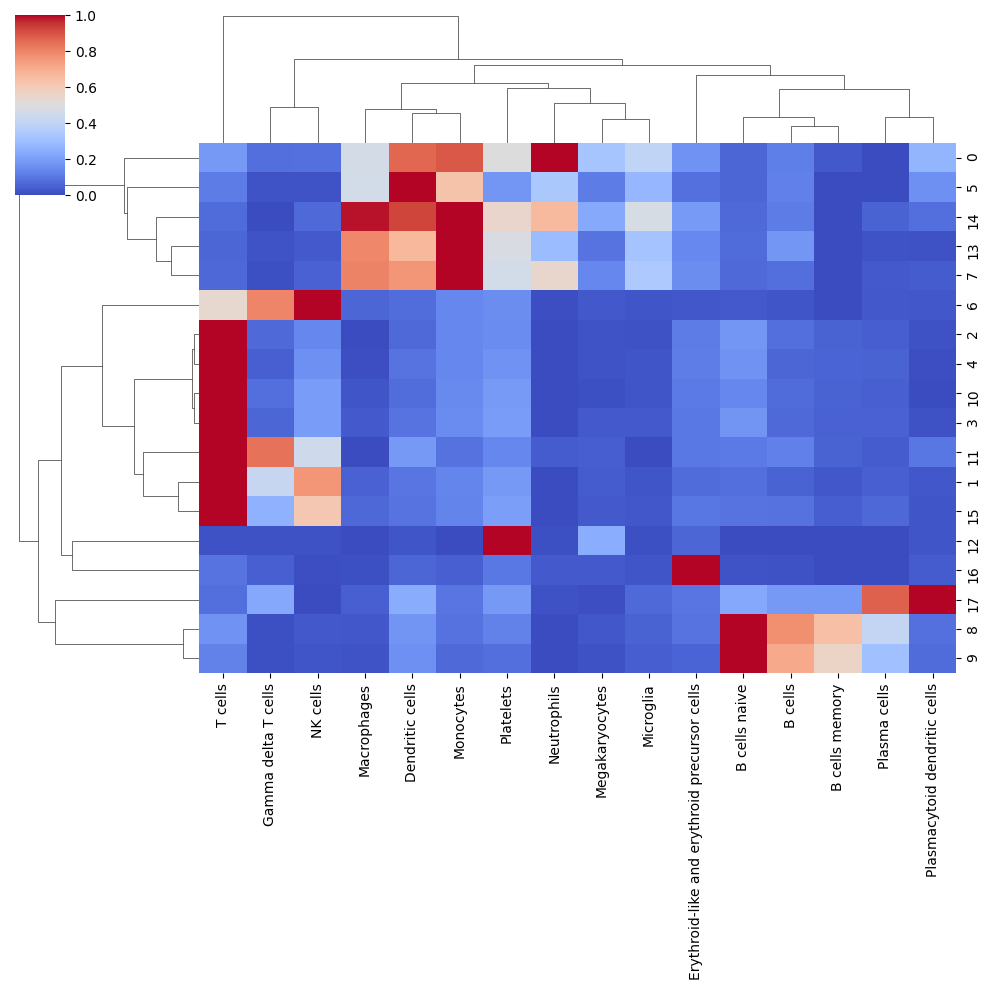

In [42]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='coolwarm', standard_scale=0)
plt.show()

We can manually annotate the clusters based on the enrichment, or we can use a function from `decoupler` that selects the
most enriched annotation per cluster:

In [43]:
# Automatically select top predicted cell type per cluster
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'Neutrophils',
 '1': 'T cells',
 '10': 'T cells',
 '11': 'T cells',
 '12': 'Platelets',
 '13': 'Monocytes',
 '14': 'Monocytes',
 '15': 'T cells',
 '16': 'Erythroid-like and erythroid precursor cells',
 '17': 'Plasmacytoid dendritic cells',
 '2': 'T cells',
 '3': 'T cells',
 '4': 'T cells',
 '5': 'Dendritic cells',
 '6': 'NK cells',
 '7': 'Monocytes',
 '8': 'B cells naive',
 '9': 'B cells naive'}

With the new annotation we can update the cell metadata and visualize

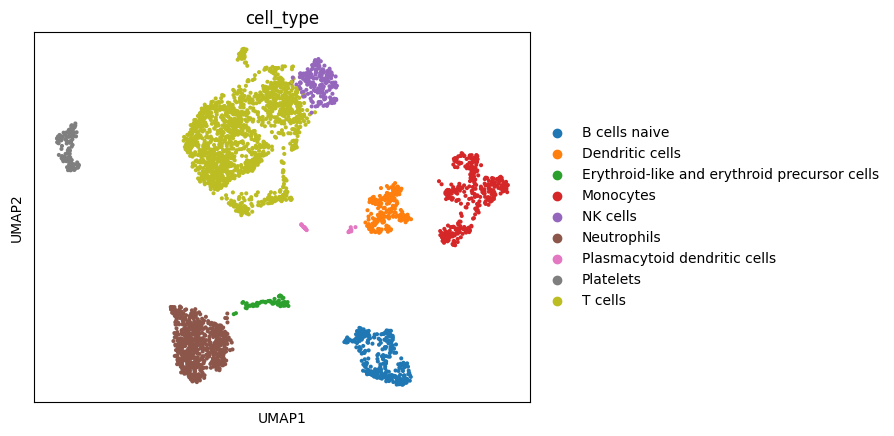

In [44]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

NOTE: In this case the automatic annotation of cell types worked nicely but this should be always checked by an expert in the biological system being studied.

## Differential Expression Analysis (DEA)

After the annotation of clusters into cell indentities, we often would like to perform differential expression analysis (DEA) between conditions within particular cell types to further characterise them. DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample. We know that single cells within a sample are not independent of each other, since they were isolated from the same enviroment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results.

The current best practice to correct for this is using a pseudo-bulk approach, which involves the following steps:

1. Subsetting the cell type(s) of interest to perform DEA.
2. Extracting their raw integer counts.
3. Summing their counts per gene into a single profile if they pass quality control.
4. Normalize aggregated counts.
5. Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).

A crucial step of pseudo-bulking is filtering out genes that are not expressed across most cells and samples, since they are very noisy and can result in unstable log fold changes. `decoupler` has a helper function that performs pseudo-bulking. To get robust profiles, genes are filtered out if they are not expressed in an enough proportion of cells per sample (`min_prop`) and if this requirement is not true across enough samples (`min_smpls`).

In [45]:
# Get pseudo-bulk profile
padata = dc.get_pseudobulk(adata, sample_col='sample_id', groups_col='cell_type', layer='counts', min_prop=0.2, min_smpls=3)

# Normalize
sc.pp.normalize_total(padata, target_sum=1e4)
sc.pp.log1p(padata)
padata

/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/decoupler/utils_anndata.py:268: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/home/badi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 32 × 7365
    obs: 'sample_id', 'condition', 'batch', 'cell_type'
    uns: 'log1p'

Once we have generated robust pseudo-bulk profiles for each sample and cell type, we can run any statistical test to compute DEA. For this example we will use t-test as is implemented in scanpy but we could use any other.

In [46]:
logFCs, pvals = dc.get_contrast(padata,
                                group_col='cell_type',
                                condition_col='condition',
                                condition='covid',
                                reference='control',
                                method='t-test'
                               )
logFCs

,A1BG,AAGAB,AAK1,AAMP,AAR2,AARS1,AARS2,AATF,AATF-1,ABCB1,...,ZRANB2,ZRSR2,ZSCAN2,ZSWIM6,ZSWIM7,ZSWIM8,ZXDC,ZYG11B,ZYX,ZZEF1
B cells naive,-0.695756,0.00000,-1.181385,0.000000,0.000000,0.636842,-0.194534,-0.111884,0.000000,0.000000,...,-0.089550,0.006110,0.000000,0.000000,0.000000,0.000000,0.000000,0.965155,0.000000,0.228279
Dendritic cells,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Monocytes,-0.150854,-0.30146,0.290070,0.330853,1.255615,0.634714,0.537959,-0.583964,0.024772,0.000000,...,0.266832,0.146210,0.254742,0.111009,0.051165,0.404000,0.153299,0.512849,0.451267,0.145024
NK cells,0.000000,0.00000,-0.040727,0.000000,0.000000,0.000000,0.000000,0.047430,0.000000,-0.150639,...,0.294128,-0.343749,0.000000,0.000000,0.000000,0.195674,0.000000,0.156584,0.000000,-0.121702
Neutrophils,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014061
T cells,-0.360406,0.00000,-0.216832,0.000000,0.000000,0.479775,0.000000,-0.157460,-0.113927,0.000000,...,-0.002940,0.061071,0.000000,0.000000,0.054785,0.000000,0.000000,0.312430,0.483740,0.126552


We can transform these results into a dataframe and store them for future use:

In [47]:
deg = dc.format_contrast_results(logFCs, pvals)
deg.to_csv('deg.csv', index=False)
deg

,contrast,name,logFCs,pvals,adj_pvals
0,B cells naive,RBM34,1.174709,0.000041,0.303025
1,B cells naive,HLA-DPB1-4,7.916212,0.000387,1.0
2,B cells naive,KDM5C,-1.128315,0.000988,1.0
3,B cells naive,HLA-F-2,-0.692687,0.003163,1.0
4,B cells naive,CD37,-0.339621,0.003946,1.0
...,...,...,...,...,...
44185,T cells,CCDC198,0.000000,1.000000,1.0
44186,T cells,PLAA,0.000000,1.000000,1.0
44187,T cells,CCDC32,0.000000,1.000000,1.0
44188,T cells,FIG4,0.000000,1.000000,1.0


We can also visualize the results as a volcano plot:

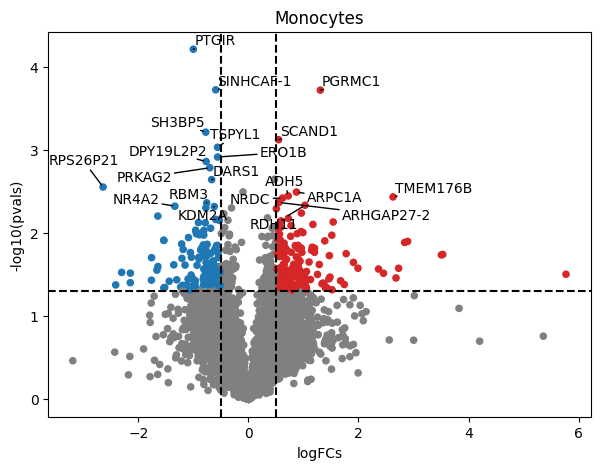

In [48]:
dc.plot_volcano(logFCs, pvals, 'Monocytes', top=20, sign_thr=0.05, lFCs_thr=0.5)

## Functional enrichment of biological terms

While some of these genes might be informative, it is rather hard to make a biological interpretation of what is going on.

As such, a simple way to reduce the dimensionality of our data and improve its interpretability is to aggregate it using biologically-meaningful functional terms.

To do so, we can leverage [decoupler](decoupler-py.readthedocs.io/) (Badia-i-Mompel et al, 2022) again,
an ensemble of different statistical methods to extract biological activities from omics data and prior knowledge within a unified framework.

<img src="https://decoupler-py.readthedocs.io/en/latest/_images/graphical_abstract.png"
     width="400" 
     height="500" />

A well-known example of prior knowledge is the `MSigDB` resource (Subramanian et al, 2005), which is a resource of tens of thousands of annotated gene sets.

To retrieve it we can use `decoupler` to access OmniPath (Türei et al, 2020), a meta-resource of databases:

In [49]:
# We retrieve MSigDB resource via OmniPath
msigdb = dc.get_resource('MSigDB')

Inside MSigDB there are many different collections of gene sets. One example is the Hallmark gene sets that are a
commonly-used collection with specific and well-defined biological processes. They were manually curated based on the overlaps with other
MSigDB collections. Hence, they represent the least biologically-redudant gene sets in MSigDB.

We can filter the dataframe for hallmark gene sets and remove duplicated entries:

In [50]:
# Format MSigDB
msigdb = msigdb[msigdb['collection']=='hallmark']
msigdb.geneset = [x[9:] for x in msigdb.geneset] # remove 'HALLMARK' from name
msigdb = msigdb.drop_duplicates(['geneset', 'genesymbol'])

Once we have our data and prior knowledge we need a statistical method to infer these so called biological activities.

Over Representation Analysis (ORA), also known as one-sided Fisher exact tests, is perhaps one of the most used methods. It
estimates how likely a collections of genes are to belong to a given gene set.

In our case, we want to know if the obtained DEG within each clusters are enriched by any biological terms.

Therefore, first we need to filter the significant genes per cell type comparison:

In [51]:
top_genes = dc.format_contrast_results(logFCs, pvals)
top_genes

,contrast,name,logFCs,pvals,adj_pvals
0,B cells naive,RBM34,1.174709,0.000041,0.303025
1,B cells naive,HLA-DPB1-4,7.916212,0.000387,1.0
2,B cells naive,KDM5C,-1.128315,0.000988,1.0
3,B cells naive,HLA-F-2,-0.692687,0.003163,1.0
4,B cells naive,CD37,-0.339621,0.003946,1.0
...,...,...,...,...,...
44185,T cells,CCDC198,0.000000,1.000000,1.0
44186,T cells,PLAA,0.000000,1.000000,1.0
44187,T cells,CCDC32,0.000000,1.000000,1.0
44188,T cells,FIG4,0.000000,1.000000,1.0


Here we filter by logFCs and significant pvals:

In [52]:
top_genes = top_genes[(np.abs(top_genes['logFCs']) > 0.5) & (top_genes['pvals'] < 0.05)]
top_genes

,contrast,name,logFCs,pvals,adj_pvals
0,B cells naive,RBM34,1.174709,0.000041,0.303025
1,B cells naive,HLA-DPB1-4,7.916212,0.000387,1.0
2,B cells naive,KDM5C,-1.128315,0.000988,1.0
3,B cells naive,HLA-F-2,-0.692687,0.003163,1.0
5,B cells naive,RELA,-0.535207,0.004104,1.0
...,...,...,...,...,...
37158,T cells,PEAK1,-0.657666,0.049585,1.0
37162,T cells,ARIH1,-0.859543,0.049801,1.0
37163,T cells,CPB2,-0.816907,0.049840,1.0
37164,T cells,NCOA1,-0.597681,0.049840,1.0


Then we can easily compute ORA using `decoupler`:

In [53]:
# Get ORA p-values
enr_pvals = dc.get_ora_df(top_genes, msigdb,
                          groupby='contrast', features='name',
                          source='geneset', target='genesymbol')

# Set 0s to min p-value & log-transform
enr_pvals.values[enr_pvals.values == 0] = np.min(enr_pvals.values[enr_pvals.values != 0])
enr_pvals = -np.log10(enr_pvals)

enr_pvals

,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,APICAL_JUNCTION,APOPTOSIS,CHOLESTEROL_HOMEOSTASIS,COAGULATION,COMPLEMENT,DNA_REPAIR,E2F_TARGETS,...,OXIDATIVE_PHOSPHORYLATION,P53_PATHWAY,PEROXISOME,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,XENOBIOTIC_METABOLISM
B cells naive,1.019506,5.255889,1.452891,-0.000000,1.203758,2.982414,1.253378,2.191448,6.293324,7.146202,...,1.831324,2.359852,-0.000000,1.253378,1.375248,0.817534,4.124310,-0.000000,0.991064,-0.000000
Dendritic cells,1.357595,1.275314,1.798616,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,5.869055,1.357595,-0.000000,-0.000000,-0.000000,2.612225,1.423181,-0.000000,2.986994,-0.000000
Monocytes,6.066866,4.140989,1.174628,4.063507,7.243429,2.422544,5.630002,12.468003,5.162332,4.252785,...,7.343987,3.077502,2.736853,2.301554,2.564719,7.757303,4.799389,4.063507,5.895678,11.518799
NK cells,6.773788,8.005951,1.313951,2.702900,1.067179,2.702900,2.580797,6.294204,5.728637,6.441971,...,3.930147,8.610221,1.313951,4.287374,1.236900,14.133010,0.948580,2.702900,4.932605,1.067179
Neutrophils,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,2.377457,6.319139,2.077273,-0.000000,4.323036,-0.000000
T cells,2.184648,2.017661,1.364148,4.641159,2.574834,2.803883,1.165700,0.855209,-0.000000,3.462401,...,12.150089,3.643860,3.121062,2.681462,2.947492,1.763052,3.856905,2.803883,3.549764,4.266591


We can visualize the results across cell types:

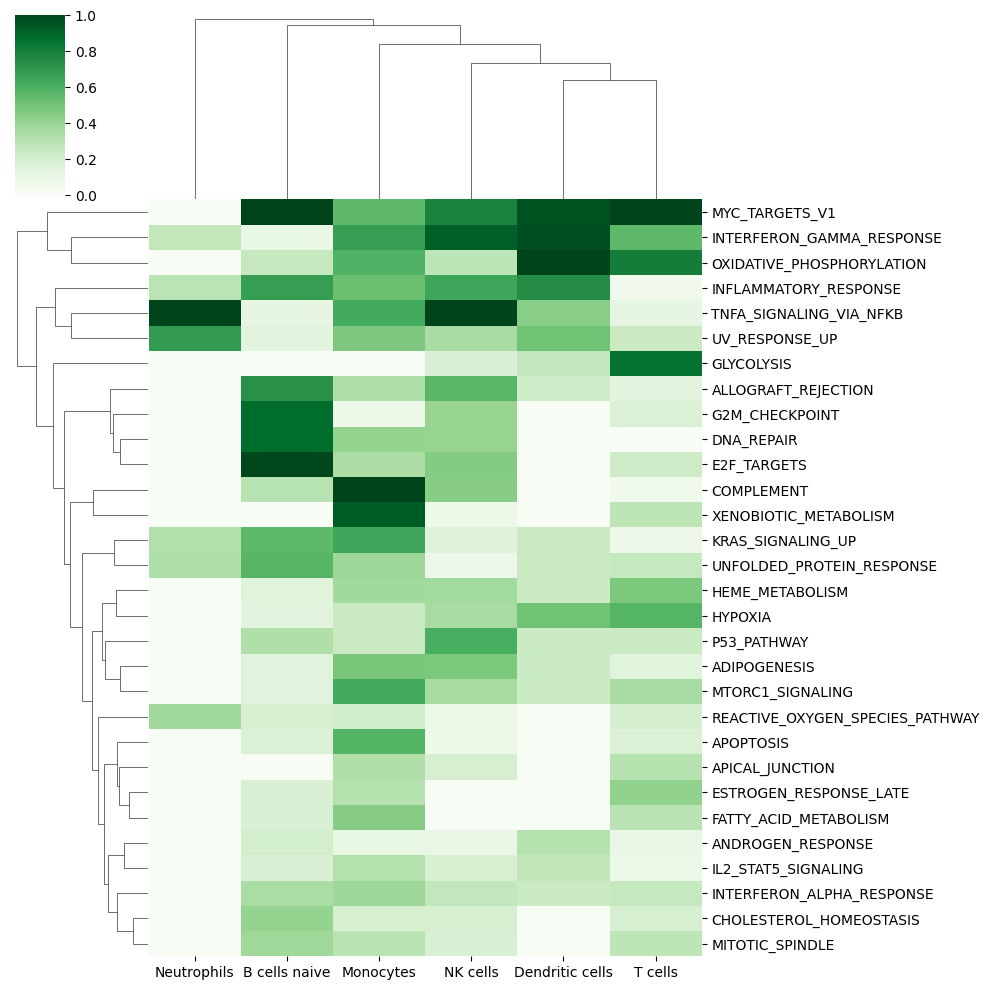

In [54]:
# Get top 10 most over-represented gene sets
top = 10
top_idxs = set()
for row in enr_pvals.values:
    sort_idxs = np.argsort(-np.abs(row))
    top_idxs.update(sort_idxs[:top])
top_idxs = np.array(list(top_idxs))
top_names = enr_pvals.columns[top_idxs]
names = enr_pvals.index.values
top = pd.DataFrame(enr_pvals.values[:, top_idxs], columns=top_names, index=names)

# Plot
sns.clustermap(top.T, cmap='Greens', standard_scale=1)
plt.show()

If we want we can also check individual results, let us plot the results for Neutrophils:

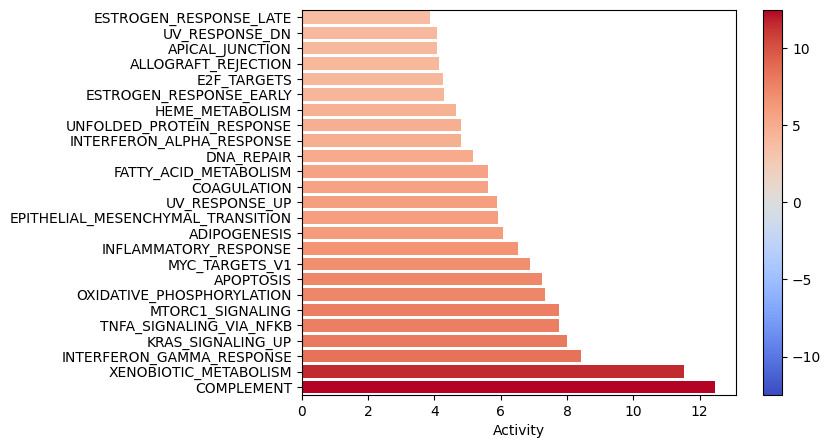

In [55]:
dc.plot_barplot(enr_pvals, 'Monocytes', top=25, vertical=True)

Using ORA we need to set an arbitrary theshold to select the genes we want to test and also we are not taking into account if
genes are positively or negatively regulated. The method Gene Set Enrichment Analysis (GSEA) (Subramanian et al, 2005) runs an increasing a running-sum
statistic when a gene in the target feature set is encountered and decreasing it when it is not.

GSEA's main advantages over ORA is that it considers all genes in the dataset, and takes both extremes into account - i.e. both genes with high and low ranking simultaneously.

We can estimate the activities again but this time using GSEA:

In [56]:
# Infer enrichment with GSEA
msigdb_scores, msigdb_nscores, msigdb_pvals = dc.run_gsea(mat=logFCs,
                                                          source='geneset',
                                                          target='genesymbol',
                                                          net=msigdb,
                                                          verbose=True)

Running gsea on mat with 6 samples and 7365 targets for 50 sources.


100%|████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


From GSEA we obtain three results: an estimate score, a normalized score and the associated p-value.
We can plot the normalized score, which is which represents both the sign and the statistical deviation of change compared to random.

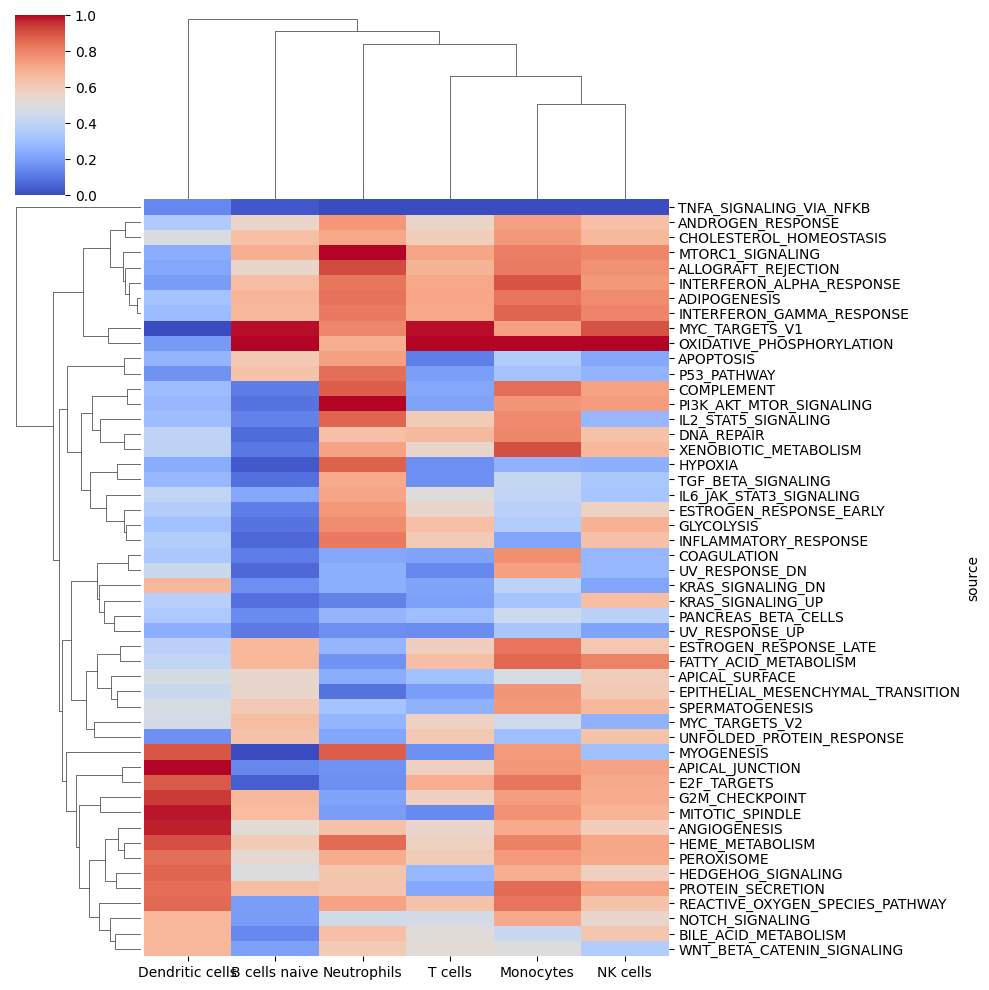

In [57]:
# Set nans to zero to be able to plot
msigdb_nscores.fillna(0, inplace=True)

sns.clustermap(msigdb_nscores.T, cmap='coolwarm', yticklabels=msigdb_nscores.columns, standard_scale=1)
plt.show()

Like before we can visualize the results for an individual cell type:

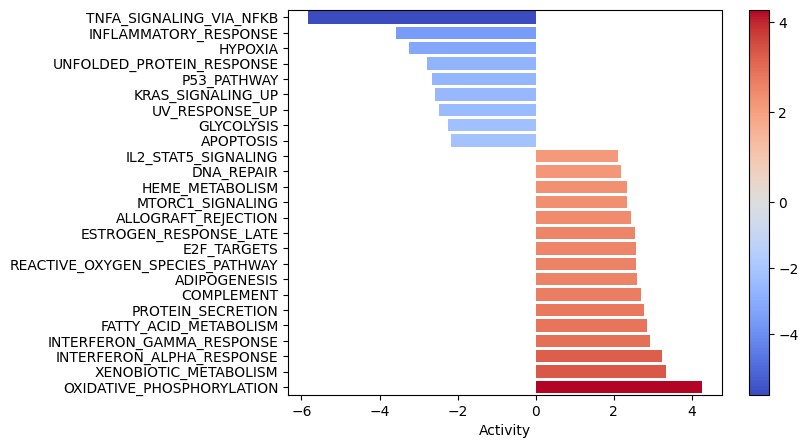

In [58]:
dc.plot_barplot(msigdb_nscores, 'Monocytes', top=25, vertical=True)

## Transcription factor activity estimation from prior-knowledge footprints

Classical gene sets in databases like MSigDB contain genes thought to be part of the same biological process.
Instead, one could use genes which change in response to a given regulator or entity. 
We term such collection of genes a `footprint`, where links from regulators to downstream targets can have weights,
something that classical gene sets ignore.

One example of footprint is a Gene Regulatory Network (GRN), where Transcription Factors (regulatory proteins) target specific downstream genes
in either a positive (activation) or negative (repression) manner.

Here is an example:

<img src="https://decoupler-py.readthedocs.io/en/latest/_images/net_plot.png"
     width="400" 
     height="500" />

As an example, we will infer TF activities using the gene regulatory network [DoRothEA](https://saezlab.github.io/dorothea/) (Garcia-Alonso et al, 2019), a comprehensive resource containing a curated collection of TFs and their transcriptional targets. Since these regulons were gathered from different types of evidence, interactions in DoRothEA are classified in different confidence levels, ranging from A (highest confidence) to D (lowest confidence). Moreover, each interaction is weighted by its confidence level and the sign of its mode of regulation (activation or inhibition).

Here we will use the human version (mouse is also available) and we will use the confidence levels ABC. To access it we can use `decoupler`:

In [59]:
dorothea = dc.get_dorothea(organism='human', levels=['A','B','C'])
dorothea

,source,confidence,target,weight
0,ETS1,A,IL12B,1.000000
1,RELA,A,IL6,1.000000
2,MITF,A,BCL2A1,-1.000000
3,E2F1,A,TRERF1,1.000000
4,MITF,A,BCL2,1.000000
...,...,...,...,...
32272,IKZF1,C,PTK2B,0.333333
32273,IKZF1,C,PRKCB,0.333333
32274,IKZF1,C,PREX1,0.333333
32275,IRF4,C,SLAMF7,0.333333


As statistic, we will use the very simple weighted mean (`wmean`) method to take both the magnitude of change (logFC) and the
weight of the TF-target interactions into account.

In [60]:
wmean_estimate, wmean_norm, wmean_corr, wmean_pvals = dc.run_wmean(mat=logFCs, net=dorothea, verbose=True)

Running wmean on mat with 6 samples and 7365 targets for 272 sources.
Infering activities on 1 batches.


100%|████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


The `wmean` returns different outputs but we will use the normalized estimate, which indicates how many standard deviations from a random background an activity is:

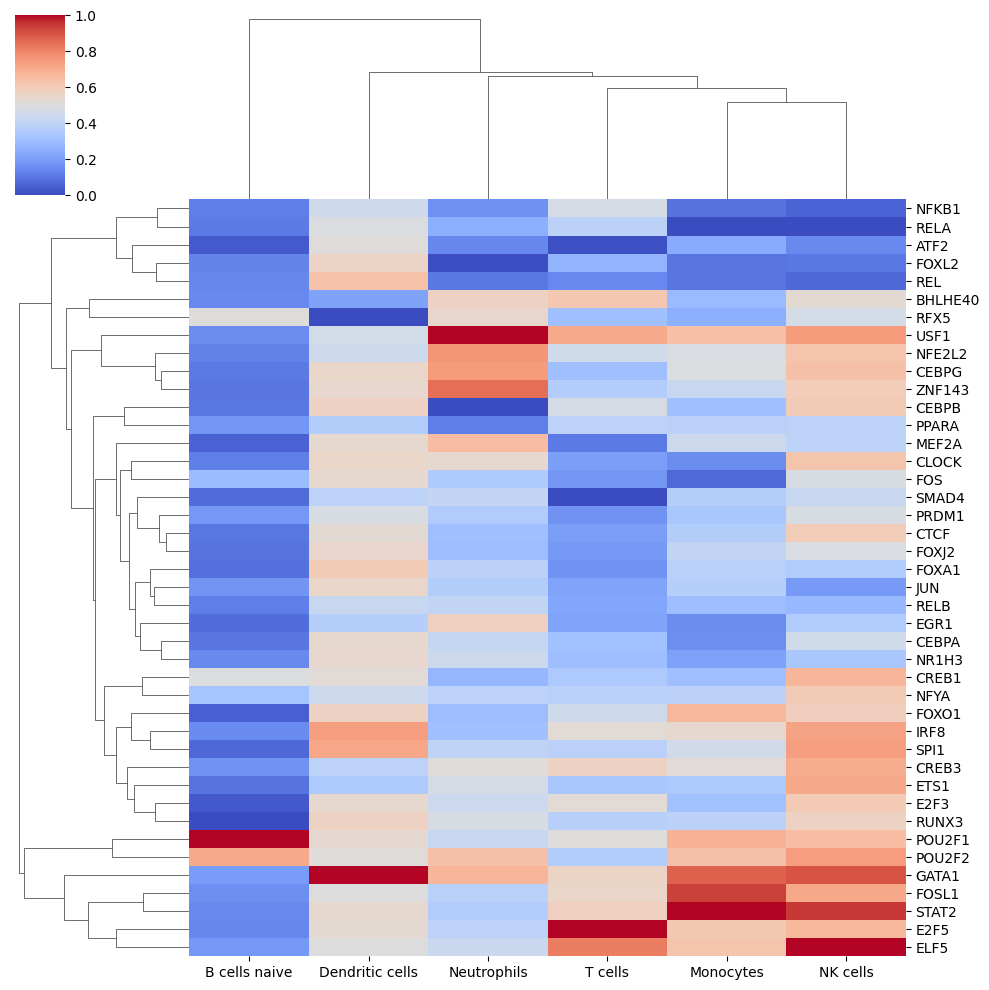

In [61]:
# Get top 10 most over-represented gene sets
top = 10
top_idxs = []
for row in wmean_norm.values:
    sort_idxs = np.argsort(-np.abs(row))
    top_idxs.extend(sort_idxs[:top])
top_idxs = np.unique(top_idxs)
top_names = wmean_norm.columns[top_idxs]
names = wmean_norm.index.values
top = pd.DataFrame(wmean_norm.values[:, top_idxs], columns=top_names, index=names)

# Plot
sns.clustermap(top.T, cmap='coolwarm', standard_scale=1, yticklabels=top.columns)
plt.show()

Here we can again show an specific example:

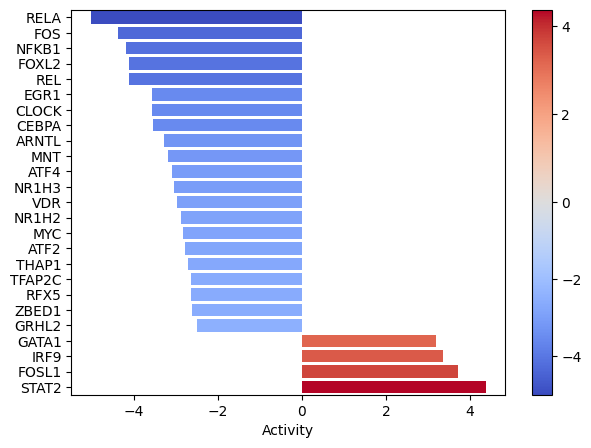

In [62]:
dc.plot_barplot(wmean_norm, 'Monocytes', top=25, vertical=True)

If we want to see gradients of activity in our cells, we can also estimate the activities at the single-cell level:

In [63]:
dc.run_mlm(mat=adata, net=dorothea, source='source', target='target', weight='weight', verbose=True, use_raw=False)

8 features of mat are empty, they will be removed.
Running mlm on mat with 3467 samples and 17237 targets for 289 sources.


100%|████████████████████████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Then we can plot the results on the UMAP:

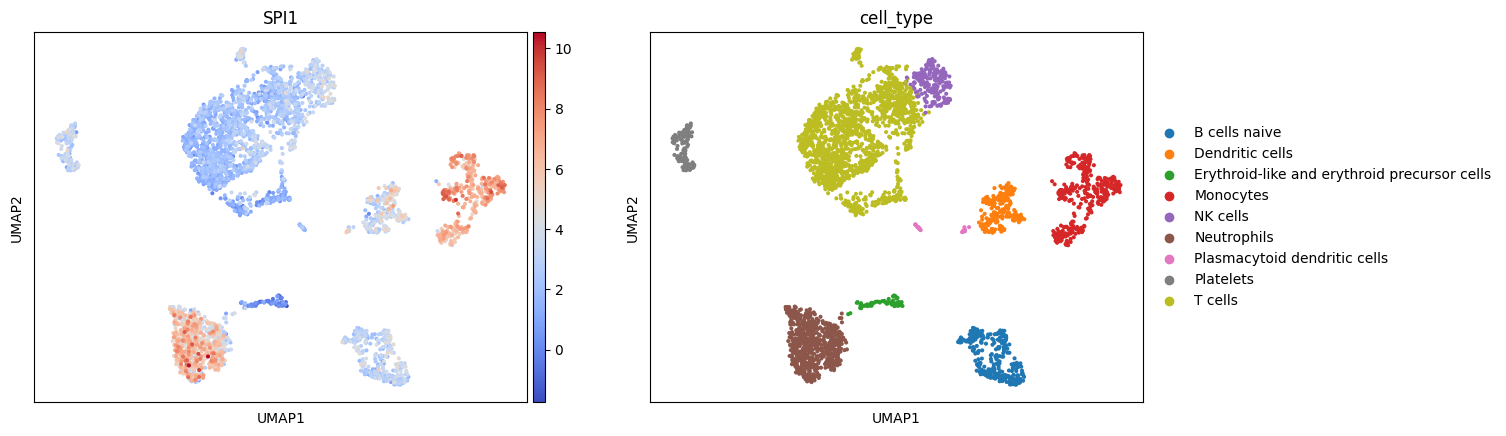

In [64]:
acts = dc.get_acts(adata, 'mlm_estimate')
sc.pl.umap(acts, color=['SPI1', 'cell_type'], cmap='coolwarm')

We can observe that the regulator SPI1 has a higher activity in Monocytes and Neutrophils. It has previously reported that SPI1 is crucial for Monocytes and Neutrophils homeostasis.

## Cytokine activity inference from prior-knowledge footprints

Other common footprints are signaling pathways. In this tutorial we will use

To estimate pathway activities we will use the [CytoSig](https://www.nature.com/articles/s41592-021-01274-5)(Jiang et al, 2021) resource, a data-driven compedium of high-quality cytokine footprint signatures. 

Cytokines often exhibit pleiotropic interactions that depend heavily on cell-type-specificity, but also the activity of other biological components, including other cytokines.
To this end, one could also consider attempting to address for these complicated relationships between cytokines.

Perhaps, the simplest way to achieve this is to fit a multi-variate model (`mlm`), which inherintly take co-linearity into account.

In a recent benchmark, we saw that `mlm` yielded the best performance at recovering perturbed regulators from pertrubation experiments.

In [65]:
# Read CytoSig signatures
# Keep top 500 genes
cytosig = pd.read_csv("src/cytosig_signatures.csv")
# Keep highest 500 weights per gene set
cytosig = (
    cytosig
    .sort_values(by='weight', key=abs, ascending=False)
    .groupby('source')
    .head(500)
    .sort_values(['source', 'weight'])
    .reset_index(drop=True)
)
cytosig

,source,target,weight
0,Activin_A,SAMHD1,-2.461276
1,Activin_A,SCG5,-1.620553
2,Activin_A,PHC1,-1.447072
3,Activin_A,ZNF589,-1.431688
4,Activin_A,POLR3G,-1.339828
...,...,...,...
21495,WNT3A,MAP1B,0.212367
21496,WNT3A,TNC,0.221110
21497,WNT3A,LBH,0.222655
21498,WNT3A,QPCT,0.262310


Then we infer activities using `mlm`:

In [66]:
# Infer pathway activities with mlm
cyto_acts, cyto_pvals = dc.run_mlm(mat=logFCs, net=cytosig, verbose=True)
cyto_acts

Running mlm on mat with 6 samples and 7365 targets for 43 sources.


100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]


,Activin_A,BDNF,BMP2,BMP4,BMP6,CD40L,CXCL12,EGF,FGF2,GCSF,...,MCSF,NO,OSM,TGFB1,TGFB3,TNFA,TRAIL,TWEAK,VEGFA,WNT3A
B cells naive,-0.009350,0.279316,-0.664762,-0.002432,0.660188,-0.215417,-0.474345,0.023005,-0.648270,0.009730,...,-0.021013,0.530395,0.063116,-0.533028,-1.009434,0.379084,-0.767125,0.320544,-0.602444,-0.156989
Dendritic cells,-1.923056,1.740648,0.982821,-0.443350,0.693231,-0.141623,-0.214438,-0.493058,-0.493691,-0.029688,...,0.473691,-0.657838,0.674646,-1.350481,-0.475346,-1.568432,-2.183291,1.254915,-2.592084,1.626764
Monocytes,-1.056297,1.699482,0.464242,-0.772994,0.260542,-0.407962,0.314346,-1.258240,-1.671422,0.085200,...,1.252253,-0.679338,0.776684,-0.799420,-1.283421,-1.084767,-2.160379,0.689200,-3.556815,1.910366
NK cells,-0.256180,-1.199441,-1.223784,0.327007,1.495666,-1.554252,-1.832663,-1.804788,1.859221,-0.211008,...,-0.107857,-0.926186,-0.897499,-0.928411,-2.892378,-0.594743,-2.393319,-1.525586,-1.448183,0.210418
Neutrophils,0.630043,-0.088008,-0.472114,-0.584009,-0.014221,-1.213538,1.027235,0.868131,0.828698,1.142461,...,1.054688,0.492373,-1.454214,0.119262,-0.049245,2.927719,0.538019,-0.206950,-3.753566,1.105854
T cells,0.503662,-0.050194,-2.015345,-0.517341,-0.392659,-3.762186,-0.492552,-3.525054,0.051223,-1.063694,...,0.049645,-1.241596,2.730773,-0.399628,-4.426068,-0.417925,-3.158701,0.204520,-2.988638,0.497937


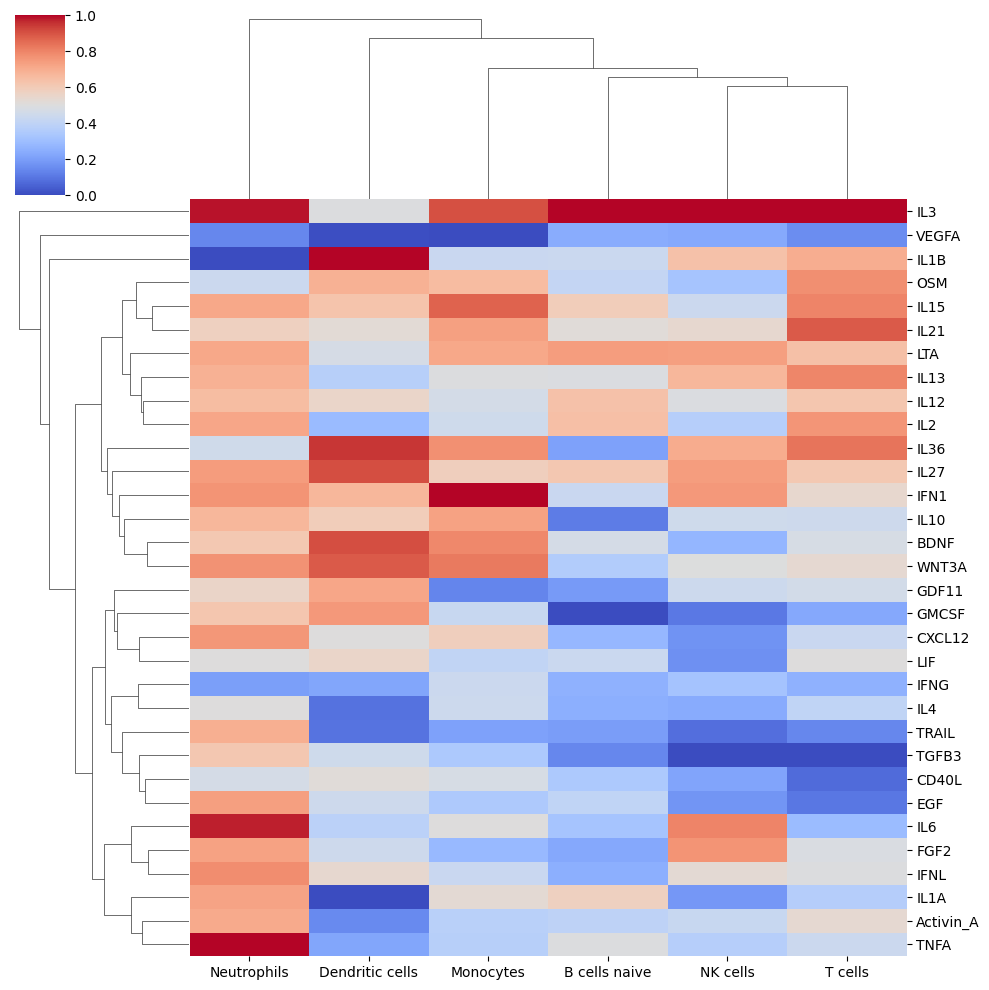

In [67]:
# Get top 10 most over-represented gene sets
top = 10
top_idxs = []
for row in cyto_acts.values:
    sort_idxs = np.argsort(-np.abs(row))
    top_idxs.extend(sort_idxs[:top])
top_idxs = np.unique(top_idxs)
top_names = cyto_acts.columns[top_idxs]
names = cyto_acts.index.values
top = pd.DataFrame(cyto_acts.values[:, top_idxs], columns=top_names, index=names)

# Plot
sns.clustermap(top.T, cmap='coolwarm', standard_scale=1, yticklabels=top.columns)
plt.show()

Q) We see multiple down- and up-regulated Cytokines across the cell types, can we tie those to the results above?

Q) Do you think that a simple linear model can capture the vast biological complexity?

## References

* Wolf, F. A., Angerer, P., & Theis, F. J. (2018). SCANPY: large-scale single-cell gene expression data analysis. Genome biology, 19(1), 1-5.
* Silvin, A., Chapuis, N., Dunsmore, G., Goubet, A.G., Dubuisson, A., Derosa, L., Almire, C., Hénon, C., Kosmider, O., Droin, N. and Rameau, P., 2020. Elevated calprotectin and abnormal myeloid cell subsets discriminate severe from mild COVID-19. Cell, 182(6), pp.1401-1418.
* Wolock, S.L., Lopez, R. and Klein, A.M., 2019. Scrublet: computational identification of cell doublets in single-cell transcriptomic data. Cell systems, 8(4), pp.281-291.
* Korsunsky, I., Millard, N., Fan, J., Slowikowski, K., Zhang, F., Wei, K., Baglaenko, Y., Brenner, M., Loh, P.R. and Raychaudhuri, S., 2019. Fast, sensitive and accurate integration of single-cell data with Harmony. Nature methods, 16(12), pp.1289-1296.
* Rozenblatt-Rosen, O., Stubbington, M.J., Regev, A. and Teichmann, S.A., 2017. The Human Cell Atlas: from vision to reality. Nature, 550(7677), pp.451-453.
* Franzén, O., Gan, L.M. and Björkegren, J.L., 2019. PanglaoDB: a web server for exploration of mouse and human single-cell RNA sequencing data. Database, 2019.
* Badia-i-Mompel, P., Vélez Santiago, J., Braunger, J., Geiss, C., Dimitrov, D., Müller-Dott, S., Taus, P., Dugourd, A., Holland, C.H., Ramirez Flores, R.O. and Saez-Rodriguez, J., 2022. decoupleR: ensemble of computational methods to infer biological activities from omics data. Bioinformatics Advances, 2(1), p.vbac016.
* Garcia-Alonso, L., Holland, C.H., Ibrahim, M.M., Turei, D. and Saez-Rodriguez, J., 2019. Benchmark and integration of resources for the estimation of human transcription factor activities. Genome research, 29(8), pp.1363-1375.
* Jiang, P., Zhang, Y., Ru, B., Yang, Y., Vu, T., Paul, R., Mirza, A., Altan-Bonnet, G., Liu, L., Ruppin, E. and Wakefield, L., 2021. Systematic investigation of cytokine signaling activity at the tissue and single-cell levels. Nature methods, 18(10), pp.1181-1191.
